Ejercicio de una Red Neuronal

Estandarizar
Balancear
(usar scaler)



In [72]:
import pandas as pd
import numpy as np

#PLT
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [73]:
#Carga de data
data = pd.read_csv('loan_data.csv')

data.head()


#Mostrar tamaño del dataset
print(data.shape)

#Mostrar tipos de columnas
data.info()

#Mostrar describe
print(data.describe())

#Mostrar primeras filas de cada columna
print(data.head())

#Guardamos variables target (Valor objetivo primer y segundo modelo)
target = 'loan_status'


(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
                age        income       yrs_exp        amount    

In [74]:
#Los dos targets para los dos modelos que haremos (los meto en una variable)
#loan_status1 = 'loan_status'
valor_objetivo1_loan_status = 'loan_status'

data[valor_objetivo1_loan_status].describe()

count    45000.000000
mean         0.222222
std          0.415744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64

### Limpieza de Datos

##### Revisar Valores Nulos


In [75]:
#Detección de valores nulos
print(data.isnull().sum())

#Detección de valores erróneos
#Mostramos los valores unicos de cada columnas categoricas
print("Valores unicos de cada columna categoricas")
for column in data.select_dtypes(include='object').columns:
    print(column, data[column].unique())
    


age                  0
gender               0
education            0
income               0
yrs_exp              0
ownership            0
amount               0
purpose             38
int_rate             0
percent_income       0
cred_hist_length     0
risk_score           0
previous_loans       0
loan_status          0
dtype: int64
Valores unicos de cada columna categoricas
gender ['female' 'male' 'femal']
education ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'OWN ']
purpose ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION' nan]
previous_loans ['No' 'Yes']


Como vemos, tenemos valores nulos en el **purpose** , además tenemos el **gender** mal con un 'femal' y dos OWN en **ownership**

Procederemos a limpiarlos

### Aplicamos técnicas de limpieza de datos

In [76]:
#Eliminar filar con campos nulos
data_clean = data.dropna()


#Repetimos la detección de valores nulos
#print(data_clean.isnull().sum())

#Corroboramos que se hayan eliminado los valores nulos
null_values = data_clean.isnull().sum().sort_values(ascending=False)
print("Cantidad de valores nulos por columna")
print(null_values)

#Quitamos registros de femal y los pasamos a female
data_clean = data_clean.replace({'femal': 'female'})
#Quitamos un OWN
data_clean = data_clean.replace({'OWN ': 'OWN'})

#Volvemos a comprobar los valores únicos
for column in data_clean.select_dtypes(include='object').columns:
    print(column, data_clean[column].unique())

Cantidad de valores nulos por columna
age                 0
gender              0
education           0
income              0
yrs_exp             0
ownership           0
amount              0
purpose             0
int_rate            0
percent_income      0
cred_hist_length    0
risk_score          0
previous_loans      0
loan_status         0
dtype: int64
gender ['female' 'male']
education ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
purpose ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
previous_loans ['No' 'Yes']


Como vemos, ahora sí está limpio


### Detección de Valores Atípicos

Ahora comprobaremos las columnas con valores numéricos para detectar posibles valores atípicos. Usaremos un gráfico de cajas Box Plot para representarlos

Index(['age', 'income', 'yrs_exp', 'amount', 'int_rate', 'percent_income',
       'cred_hist_length', 'risk_score', 'loan_status'],
      dtype='object')


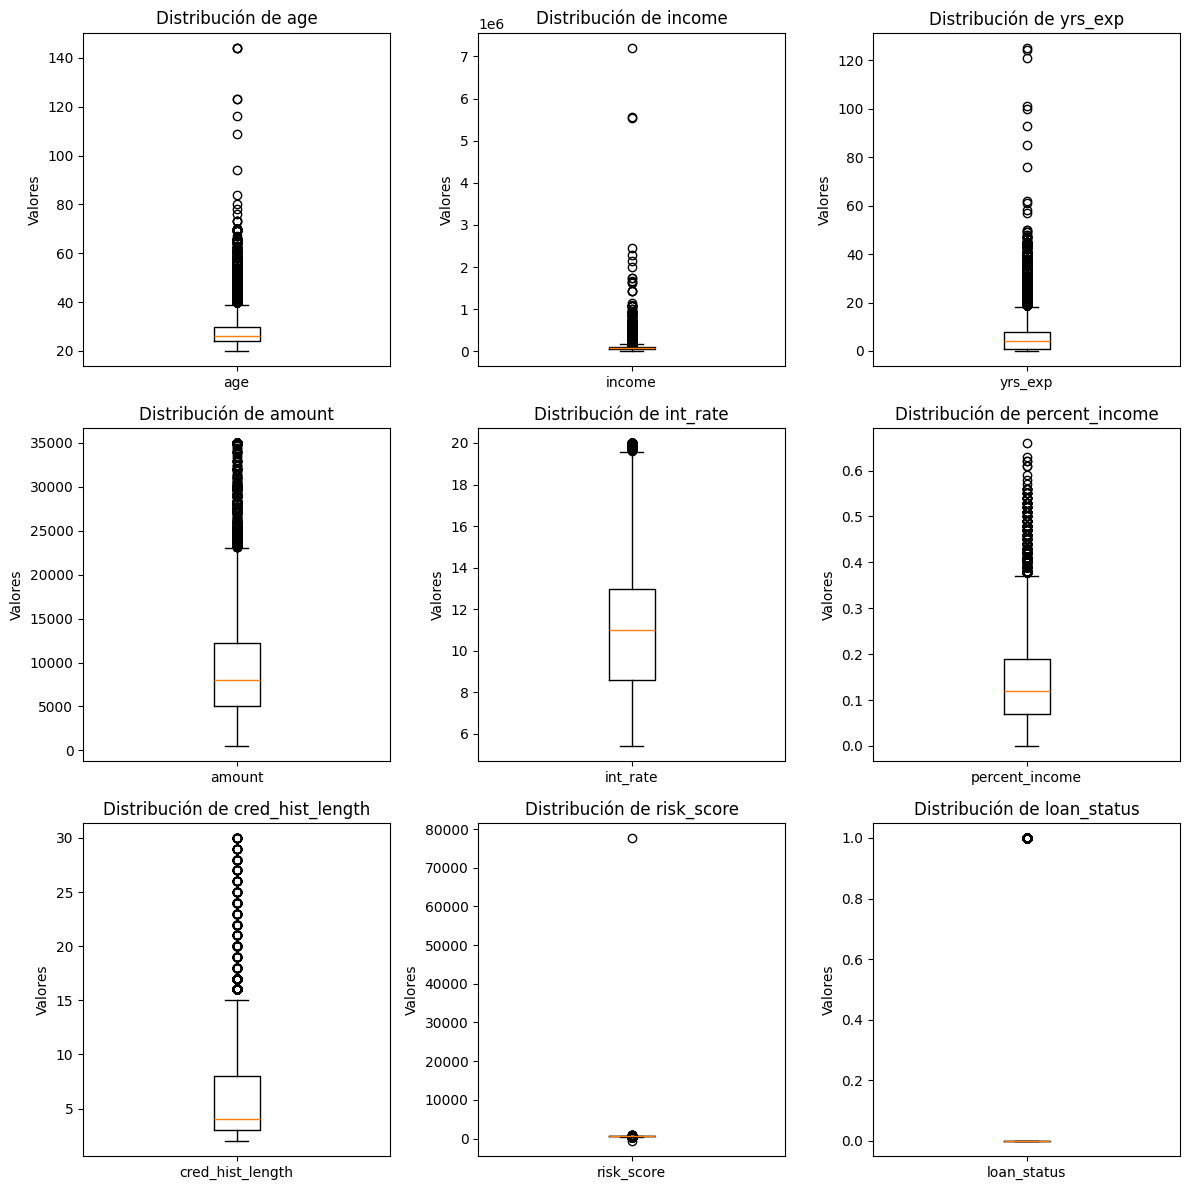

In [77]:
#Solo las numéricas (box plot solo puede representar columnas numéricas)


categorias = data_clean.select_dtypes(include='number').columns
print(categorias)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12)) #Primer 12 largo, segundo ancho

axes = axes.flatten()
for i, var in enumerate(categorias):
    axes[i].boxplot(data[var], tick_labels=[var])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_ylabel('Valores')
    
for j, in range(len(categorias), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

Si observamos podemos ver los siguientes valores atípicos:

- age (edad) -> Valores atípicos en 140 que no tienen sentido

- yrs_exp (años exp) -> Valores atípicos en 120 que no tienen sentido

- risk_score (riesgo) -> Un valor atípico en 80000 que se aleja mucho de los demás


Teniendo esto vamos a ajustar los valores de dichas columnas

En el caso de **yrs_exp** la ajustaremos a valores entre 0 y 45 (en España se cotizan 38 años para el 100 % de la jubilación pero añadiremos algunos años más) El resto no lo queremos

En **age** ajustaremos los valores entre 0 y 120 años ya que más no es real

Y el **risk_score** eliminaremos los valores atípicos que se alejan tanto para no alterarnos los resultados posteriores

In [78]:
data_clean['risk_score'].max()

np.int64(77710)

In [79]:
#Calculamos porcentaje de valores atípicos en las columnas age y yrs_exp
total_rows = data_clean.shape[0]

#IDENTIFICACIÓN DE OUTLIERS EN EL RISK_SCORE
#Obtenemos valores atípicos del risk_score
media_risk_score = data_clean['risk_score'].mean()
#Calculamos la desviación estandar
std_risk_score = data_clean['risk_score'].std()
#Aquí almacenaremos los outliers (valores atípicos)
outliers = []

#Cálculo del valor z (z-score mide cuantas desviaciones están alejadas de la media)
for element in data_clean['risk_score'].values:
    z = abs(element - media_risk_score) / std_risk_score
    if z > 2:
        outliers.append(element)
        
#Cálculo del porcentaje de valores atípicos
#Calculamos el porcentaje de valores atipicos en las columnas age, yrs_exp y risk_score
total_outliers = (data_clean[data_clean['age'] > 100].shape[0] + data_clean[data_clean['yrs_exp'] > 51].shape[0] + len(outliers)) * 100 / total_rows
print("El total de valores atipicos es: ", round(total_outliers,4), "%")
print("Cantidad de datos antes de la limpieza: ", data_clean.shape)

#Eliminamos valores atípicos de age y yrs_exp
data_clean = data_clean[data_clean['age'] <= 120]
data_clean = data_clean[data_clean['yrs_exp'] <= 45]

#Eliminamos valores atípicos de risk_score con z-score (la ~ invierte los valores)
data_clean = data_clean[~data_clean['risk_score'].isin(outliers)] #filtra excluyendo los outliers

#Imprimimos resultados para comprobar que ya no estén los valores atípicos
print("El total de valores atipicos es: ", round(total_outliers,4), "%")
print("Cantidad de datos después de la limpieza: ", data_clean.shape)



#Mostrar describe
print(data_clean.describe())



El total de valores atipicos es:  0.0467 %
Cantidad de datos antes de la limpieza:  (44962, 14)
El total de valores atipicos es:  0.0467 %
Cantidad de datos después de la limpieza:  (44935, 14)
                age        income       yrs_exp        amount      int_rate  \
count  44935.000000  4.493500e+04  44935.000000  44935.000000  44935.000000   
mean      27.731056  7.992926e+04      5.377145   9583.666763     11.005237   
std        5.839573  6.334614e+04      5.854141   6314.994130      2.979015   
min       20.000000  8.000000e+03      0.000000    500.000000      5.420000   
25%       24.000000  4.721400e+04      1.000000   5000.000000      8.590000   
50%       26.000000  6.705000e+04      4.000000   8000.000000     11.010000   
75%       30.000000  9.579100e+04      8.000000  12235.000000     12.990000   
max       70.000000  2.448661e+06     45.000000  35000.000000     20.000000   

       percent_income  cred_hist_length    risk_score   loan_status  
count    44935.000000   

Podemos observar que los valores atípicos se han solucionado por lo que pasaremos al siguiente paso

#### Para Recordar


Antes de continuar es buena práctica verificar que el dataset esté balanceado

In [80]:
class_types = data_clean[target].value_counts()
class_proportion = data_clean[target].value_counts(normalize=True) * 100

print("Tipos de clases")
print(class_types)
print("Proporcion de clases")
print(round(class_proportion,2))

Tipos de clases
loan_status
0    34969
1     9966
Name: count, dtype: int64
Proporcion de clases
loan_status
0    77.82
1    22.18
Name: proportion, dtype: float64


El dataset muestra que está desbalanceado ya que para estar balanceado los datos deberían estar en torno a un 40-60 % o 50-50 %

En pasos posteriores aplicaremos alguna técnica para solucionarlo


## 3- Ingeniería de Características
- 3.1 Codificación de variables categóricas
- 3.2 Selección de características
- 3.3 Escalado de características

En este proceso vamos a codificar las variables categóricas (no numéricas) para darles un valor numérico

(ejemplo: si es género hombre y mujer pasarlo a 0 y 1)

### Codificación de variables categóricas
Empezaremos mostrando las columnas para saber las que tenemos que codificar

In [81]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44935 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               44935 non-null  float64
 1   gender            44935 non-null  object 
 2   education         44935 non-null  object 
 3   income            44935 non-null  float64
 4   yrs_exp           44935 non-null  int64  
 5   ownership         44935 non-null  object 
 6   amount            44935 non-null  float64
 7   purpose           44935 non-null  object 
 8   int_rate          44935 non-null  float64
 9   percent_income    44935 non-null  float64
 10  cred_hist_length  44935 non-null  float64
 11  risk_score        44935 non-null  int64  
 12  previous_loans    44935 non-null  object 
 13  loan_status       44935 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 5.1+ MB


In [82]:
#Aplicamos int a la columna age para garantizar que sea númerica
data_clean['age'] = data_clean['age'].astype(int)

#Convertimos todas las columnas object a category
gender_map = {'male': 0, 'female': 1} #Añadimos valores del 0 y 1
data_clean['gender_encoded'] = data_clean['gender'].map(gender_map)
data_clean.drop(['gender'], axis=1)

#Añadimos a education sus 4 valores
education_map = {'High Schoool': 0, 'Associte': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
data_clean['education_encoded'] = data_clean['education'].map(education_map)

#Aplicamos int para garantizar que sea numérica
data_clean['education_encoded'] = data_clean['education_encoded'].fillna(0) #Quita NaN
data_clean['education_encoded'] = data_clean['education_encoded'].astype(int)
data_clean.drop(['education'], axis=1) #1 quiere decir que elimina una columna, no fila

data_ownership = pd.get_dummies(data_clean['ownership'], prefix='ownership', dtype=int, drop_first=True)
data_clean = pd.concat([data_clean, data_ownership], axis=1)

data_purpose = pd.get_dummies(data_clean['purpose'], prefix='purpose', dtype=int, drop_first=True)
data_clean = pd.concat([data_clean, data_purpose], axis=1)

data_previous_loans = {'No': 0, 'Yes': 1}
data_clean['previous_loans_encoded'] = data_clean['previous_loans'].map(data_previous_loans)
data_clean['previous_loans_encoded'] = data_clean['previous_loans_encoded'].astype(int)

#Eliminamos las columnas básicas porque se han generado nuevas (gender_encoded 0,1)
#Y se le añade a una nueva variable (data_encoded)
data_encoded = data_clean.drop(['gender','education','ownership', 'purpose', 'previous_loans'], axis=1)

data_encoded.info()
data_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 44935 entries, 0 to 44999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      44935 non-null  int64  
 1   income                   44935 non-null  float64
 2   yrs_exp                  44935 non-null  int64  
 3   amount                   44935 non-null  float64
 4   int_rate                 44935 non-null  float64
 5   percent_income           44935 non-null  float64
 6   cred_hist_length         44935 non-null  float64
 7   risk_score               44935 non-null  int64  
 8   loan_status              44935 non-null  int64  
 9   gender_encoded           44935 non-null  int64  
 10  education_encoded        44935 non-null  int64  
 11  ownership_OTHER          44935 non-null  int64  
 12  ownership_OWN            44935 non-null  int64  
 13  ownership_RENT           44935 non-null  int64  
 14  purpose_EDUCATION        44

,age,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,loan_status,gender_encoded,education_encoded,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE,previous_loans_encoded
0,22,71948.0,0,35000.0,16.02,0.49,3.0,561,1,1,3,0,0,1,0,0,0,1,0,0
1,21,12282.0,0,1000.0,11.14,0.08,2.0,504,0,1,0,0,1,0,1,0,0,0,0,1
2,25,12438.0,3,5500.0,12.87,0.44,3.0,635,1,1,0,0,0,0,0,0,1,0,0,0
3,23,79753.0,0,35000.0,15.23,0.44,2.0,675,1,1,2,0,0,1,0,0,1,0,0,0
4,24,66135.0,1,35000.0,14.27,0.53,4.0,586,1,0,3,0,0,1,0,0,1,0,0,0


### Selección de Características

Vamos a seleccionar las columnas más relevantes con el valor target

Para saber cuales son usaremos un mapa de calor (Mapa de calor de correlación)

Este mapa nos mostrará de forma gráfica las correlaciones entre las columnas y según la correlación sea más cercana al 1 mejor tanto positiva como en negativo

- Valores cercanos a -1 o a 1 indican una fuerte correlación con la **target**

- Valores cercanos a 0 indican poca o ninguna correlación con la **target**

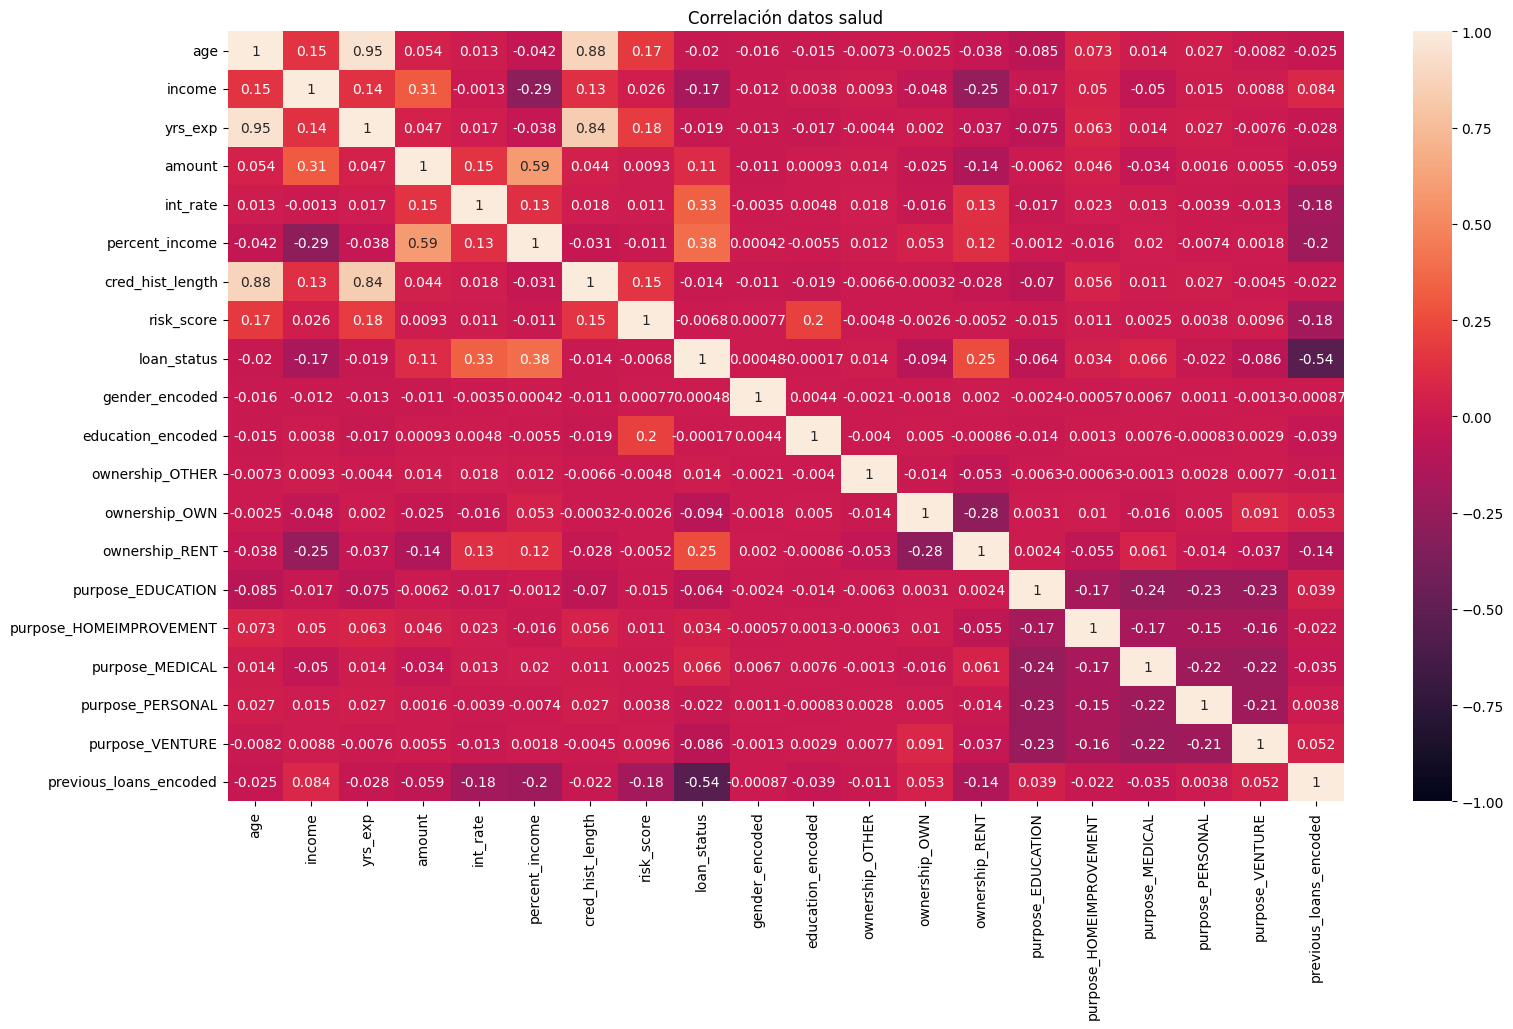

In [83]:
plt.figure(figsize=(18, 10)) 
heatmap = sns.heatmap(data_encoded.corr(), vmin=-1, vmax=1, annot=True) 
heatmap.set_title('Correlación datos salud') 
plt.show()

Revisado el gráfico nos vamos a quedar con una selección de las columnas más relevantes relacionadas con **loan_status** porque su correlación es la más cercana. Son las siguientes:

- income                 (-0.17)
- amount                 (0.11)
- int_rate               (0.33)
- percent_income         (0.39)
- previous_loans_encoded (-0.52)


### Escalado de Características

Definimos una lista de columnas relevantes para el analisis

Visualización Inicial los datos

Hacemos escalado de las variables numéricas (Estandarización)

Visualización Final después del escalado

In [84]:

#Columnas relevantes de loans_status
columnas_relevantes = ['income','amount','int_rate','percent_income','previous_loans_encoded']
data_encoded = data_encoded[columnas_relevantes + [target]]


#Mostramos información
print(data_encoded.head())

data_encoded.info()

#Escalamos las variables numéricas (solo numéricas)
scaler = StandardScaler()
data_encoded[['income','amount','int_rate','percent_income']] = scaler.fit_transform(data_encoded[['income', 'amount', 'int_rate', 'percent_income']])

print('Columnas escaladas')
print(data_encoded.head())


    income   amount  int_rate  percent_income  previous_loans_encoded  \
0  71948.0  35000.0     16.02            0.49                       0   
1  12282.0   1000.0     11.14            0.08                       1   
2  12438.0   5500.0     12.87            0.44                       0   
3  79753.0  35000.0     15.23            0.44                       0   
4  66135.0  35000.0     14.27            0.53                       0   

   loan_status  
0            1  
1            0  
2            1  
3            1  
4            1  
<class 'pandas.core.frame.DataFrame'>
Index: 44935 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   income                  44935 non-null  float64
 1   amount                  44935 non-null  float64
 2   int_rate                44935 non-null  float64
 3   percent_income          44935 non-null  float64
 4   previous_loans_encoded  44935 non

RED NEURONAL SIN BALANCEO (Tiene que dar un mal resultado)

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input



#Creamos el modelo de red neuronal
model = Sequential([
 Input(shape=(X_train.shape[1],)), #Definir forma de la entrada 1 porque son filas
 Dense(16, activation='relu'), #1a capa oculta
 Dense(8, activation='relu'), #2a capa oculta
 Dense(1, activation='sigmoid') #Salida (sigmoid porque es binaria)
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Mostramos configuración
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
#Lanzamos el entrenamiento
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7778 - loss: 0.4370 - val_accuracy: 0.8890 - val_loss: 0.2414
Epoch 2/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8932 - loss: 0.2345 - val_accuracy: 0.8918 - val_loss: 0.2365
Epoch 3/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8931 - loss: 0.2310 - val_accuracy: 0.8912 - val_loss: 0.2355
Epoch 4/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8995 - loss: 0.2236 - val_accuracy: 0.8914 - val_loss: 0.2336
Epoch 5/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8925 - loss: 0.2350 - val_accuracy: 0.8919 - val_loss: 0.2338
Epoch 6/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8943 - loss: 0.2348 - val_accuracy: 0.8921 - val_loss: 0.2348
Epoch 7/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8985 - loss: 0.2247 - val_accuracy: 0.8937 - val_loss: 0.2323
Epoch 8/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8981 - loss: 0.2266 - val_accuracy: 0.

In [87]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9083 - loss: 0.2149
Pérdida: 0.22119204699993134, Precisión: 0.9033047556877136


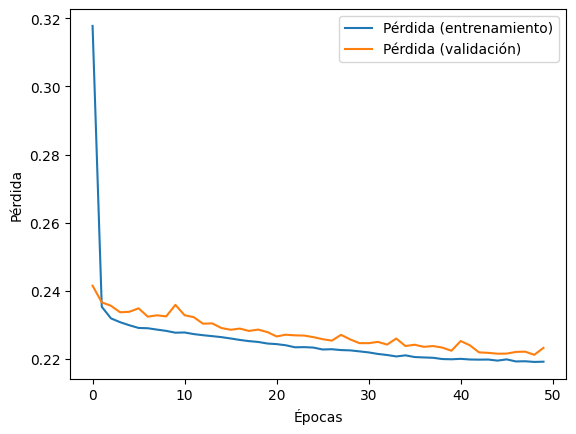

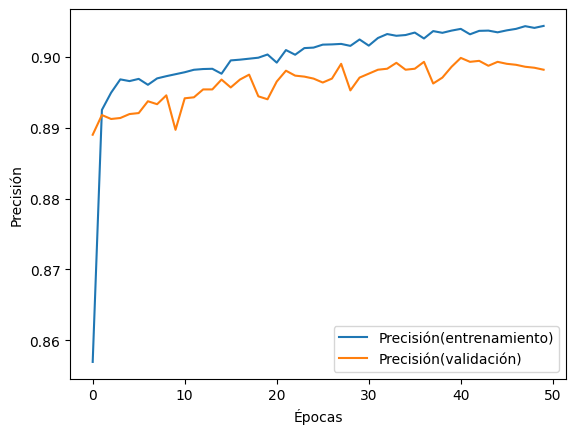

In [88]:
import matplotlib.pyplot as plt
#Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
#Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Una vez realizado el escalado con las variables numéricas podemos entrenar el modelo. Pero antes debemos tener en cuenta que estaba desbalanceado

Como este desbalanceo podría influir en el rendimiento del modelo (más en clasificación) vamos a aplicar la técnica SMOTE. También podríamos hacer sobremuestreo (oversampling) con la clase minoritaria o submuestreo (undersampling) con la clase mayoritaria

#### Técnica SMOTE para Desbalanceo 📓



In [89]:
#Separar características (X) de variable objetivo (y)
X = data_encoded.drop('loan_status', axis=1) #Reemplaza loan_status con tu columna objetivo
y = data_encoded['loan_status']

#Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Aplicar SMOTE en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Verificar que se ha balanceado
print("Distribución original: ", Counter(y_train))
print("Distribución con SMOTE: ", Counter(y_train_smote))

Distribución original:  Counter({0: 27982, 1: 7966})
Distribución con SMOTE:  Counter({1: 27982, 0: 27982})


### En redes neuronales los dataframes tienen que estandarizarse SIEMPRE

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input



#Creamos el modelo de red neuronal
model = Sequential([
 Input(shape=(X_train.shape[1],)), #Definir forma de la entrada 1 porque son filas
 Dense(16, activation='relu'), #1a capa oculta
 Dense(8, activation='relu'), #2a capa oculta
 Dense(1, activation='sigmoid') #Salida (sigmoid porque es binaria)
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Mostramos configuración
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [91]:
#Lanzamos el entrenamiento
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7781 - loss: 0.4749 - val_accuracy: 0.8910 - val_loss: 0.2380
Epoch 2/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8926 - loss: 0.2374 - val_accuracy: 0.8936 - val_loss: 0.2349
Epoch 3/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8946 - loss: 0.2319 - val_accuracy: 0.8921 - val_loss: 0.2344
Epoch 4/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8942 - loss: 0.2322 - val_accuracy: 0.8950 - val_loss: 0.2321
Epoch 5/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8961 - loss: 0.2289 - val_accuracy: 0.8957 - val_loss: 0.2320
Epoch 6/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8997 - loss: 0.2261 - val_accuracy: 0.8969 - val_loss: 0.2312
Epoch 7/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.2281 - val_accuracy: 0.8917 - val_loss: 0.2322
Epoch 8/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8969 - loss: 0.2271 - val_accuracy: 0.

In [92]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9068 - loss: 0.2190
Pérdida: 0.22435112297534943, Precisión: 0.9028596878051758


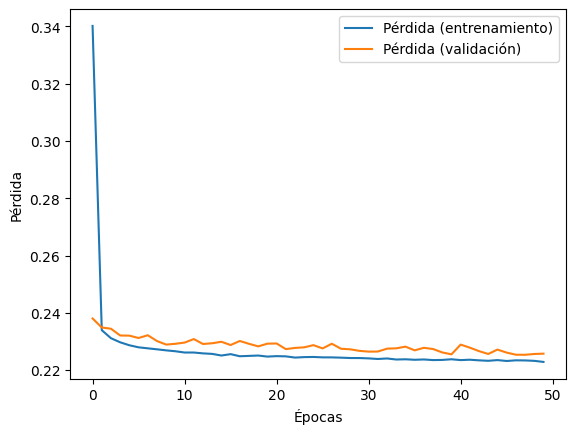

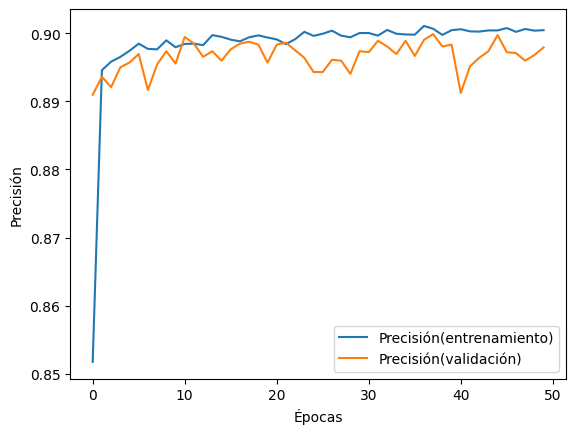

In [93]:
import matplotlib.pyplot as plt
#Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
#Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()